In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
f1_score, roc_curve, auc, precision_recall_curve, average_precision_score) 
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint

In [8]:
class DataPreparation:
    
    def __init__(self, data_path, selected_features, label):
        self.data_path = data_path
        self.selected_features = selected_features
        self.label = label
    
    def load_data(self):
        self.df = pd.read_csv(self.data_path)
        self.df['label'] = self.df['label'].apply(lambda x: x if x == 'normal' else 'attack')
    
    def data_preparation(self):
        le = LabelEncoder()
        self.df[self.label] = le.fit_transform(self.df[self.label])
        X = self.df[self.selected_features]
        y = self.df[self.label]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
class KNNClassifierModel:
    
    def __init__(self, k):
        self.model = KNeighborsClassifier(n_neighbors=k)
    
    def train_model(self, X_train, y_train):
        t0 = time.time()
        self.model.fit(X_train, y_train)
        training_time = time.time() - t0
        return training_time
        
    def evaluate_model(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        class_report = classification_report(y_test, y_pred)
        return accuracy, conf_matrix, f1, class_report
    
    def hyperparameter_tuning(self, X_train, y_train):
        param_dist = {
            'n_neighbors': randint(1, 20),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }

        random_search = RandomizedSearchCV(self.model, param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)
        random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        return random_search.best_params_, best_model
    
    def plot_confusion_matrix(self, y_test, y_pred):
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['non-attack', 'attack'], yticklabels=['non-attack', 'attack'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    
    def plot_roc_curve(self, X_test, y_test):
        y_pred_proba = self.model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve (ROC)')
        plt.legend(loc="lower right")
        plt.show()
    
    def plot_classification_report(self, y_test, y_pred):
        report = classification_report(y_test, y_pred, output_dict=True)
        rep_df = pd.DataFrame(report).transpose()

        plt.figure(figsize=(10,7))
        sns.heatmap(rep_df.iloc[:-1, :-1].astype(float), annot=True, cmap="Blues")
        plt.title('Classification Report Heatmap')
        plt.tight_layout()
        plt.show()

    def plot_precision_recall_curve(self, X_test, y_test):
        y_pred_proba = self.model.predict_proba(X_test)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        average_precision = average_precision_score(y_test, y_pred_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.show()

    def cross_validation_metrics(self, X, y):
        cv_accuracy = cross_val_score(self.model, X, y, cv=5, scoring='accuracy')
        cv_precision = cross_val_score(self.model, X, y, cv=5, scoring='precision')
        cv_recall = cross_val_score(self.model, X, y, cv=5, scoring='recall')
        cv_f1 = cross_val_score(self.model, X, y, cv=5, scoring='f1')
        cv_roc_auc = cross_val_score(self.model, X, y, cv=5, scoring='roc_auc')

        return cv_accuracy.mean(), cv_precision.mean(), cv_recall.mean(), cv_f1.mean(), cv_roc_auc.mean()

In [10]:
selected_features = ['dst_host_same_src_port_rate',
 'is_guest_login',
 'num_failed_logins',
 'dst_host_diff_srv_rate',
 'rerror_rate',
 'logged_in',
 'serror_rate',
 'same_srv_rate',
 'protocol_type_0',
'protocol_type_1', 
 'dst_host_srv_diff_host_rate']

In [11]:
data_prep = DataPreparation("../../../transformed_datasets/transformed_NSL_KDD_2.csv", selected_features, 'label')

In [12]:
data_prep.load_data()

In [13]:
data_prep.data_preparation()

In [14]:
knn_model = KNNClassifierModel(k=3)

In [15]:
knn_model.train_model(data_prep.X_train, data_prep.y_train)

0.016839981079101562

In [16]:
accuracy, conf_matrix, f1, class_report = knn_model.evaluate_model(data_prep.X_test, data_prep.y_test)

In [17]:
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"F1 Score: {f1}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.9228210246174318
Confusion Matrix:
[[2414  170]
 [ 178 1747]]
F1 Score: 0.9228003154232011
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2584
           1       0.91      0.91      0.91      1925

    accuracy                           0.92      4509
   macro avg       0.92      0.92      0.92      4509
weighted avg       0.92      0.92      0.92      4509



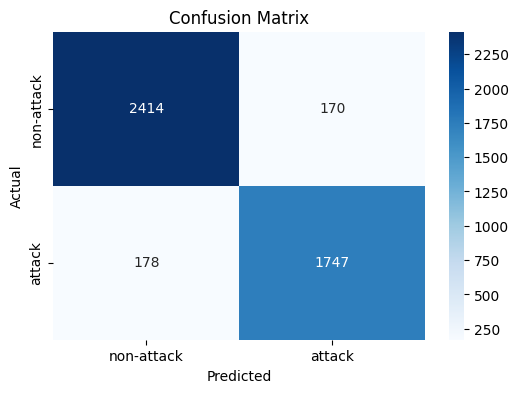

In [18]:
knn_model.plot_confusion_matrix(data_prep.y_test, knn_model.model.predict(data_prep.X_test))

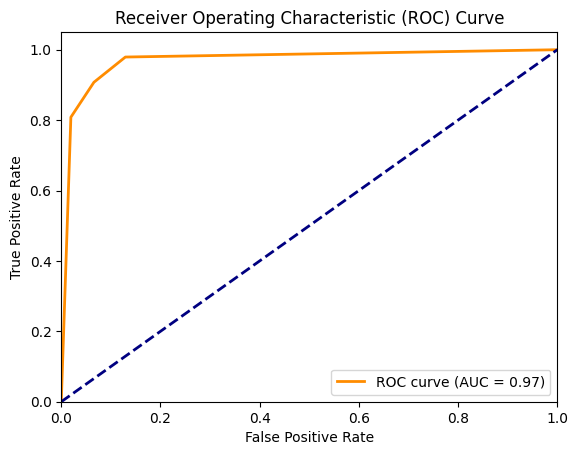

In [19]:
knn_model.plot_roc_curve(data_prep.X_test, data_prep.y_test)

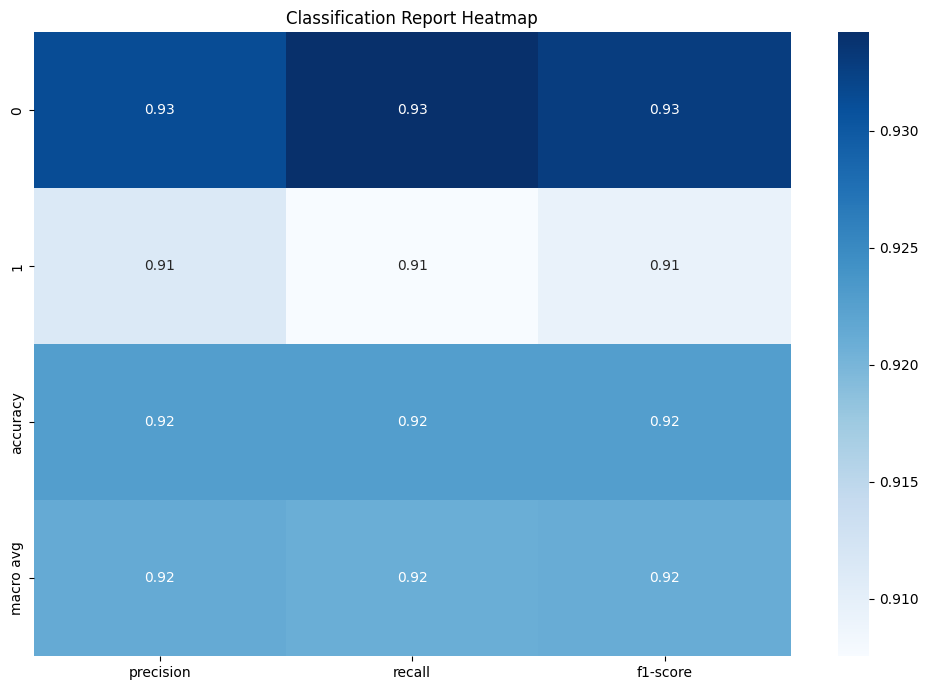

In [20]:
knn_model.plot_classification_report(data_prep.y_test, knn_model.model.predict(data_prep.X_test))

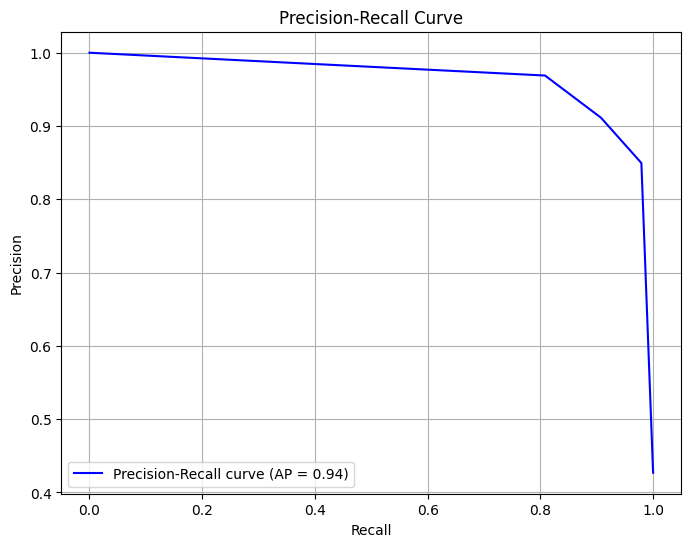

In [21]:
knn_model.plot_precision_recall_curve(data_prep.X_test, data_prep.y_test)

In [22]:
cv_accuracy, cv_precision, cv_recall, cv_f1, cv_roc_auc = knn_model.cross_validation_metrics(data_prep.X_train, data_prep.y_train)

In [23]:
print(f"Cross-Validation Accuracy: {cv_accuracy}")
print(f"Cross-Validation Precision: {cv_precision}")
print(f"Cross-Validation Recall: {cv_recall}")
print(f"Cross-Validation F1 Score: {cv_f1}")
print(f"Cross-Validation ROC AUC: {cv_roc_auc}")

Cross-Validation Accuracy: 0.9274743554200168
Cross-Validation Precision: 0.9226404591652313
Cross-Validation Recall: 0.908430517526958
Cross-Validation F1 Score: 0.9152455991414907
Cross-Validation ROC AUC: 0.9572746965293263
